In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [ ]:
pip install pytesseract

`pytesseract` is a Python binding for Google's Tesseract-OCR Engine. Tesseract is an open-source optical character recognition (OCR) tool that can recognize text from images.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet #Efficient way to work with XML files

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Lebelling The Images

## PARSING DATA FROM XML AND CONVERTING IT INTO CSV

### Parsing Data from XML

In [ ]:
path = glob('/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[]) #The labels_dict is an Unstructured Data in this step
for filename in path:
  info = xet.parse(filename) #N1.jpeg
  root = info.getroot() # N1
  member_object = root.find('object') #            <name>number_plate</name>
		                                  #            <pose>Unspecified</pose>
		                                  #            <truncated>0</truncated>
		                                  #            <difficult>0</difficult>
		                                  #            <bndbox>
		                                  #	                  <xmin>1093</xmin>
	                                  	#	                  <ymin>645</ymin>
		                                  #                 	<xmax>1396</xmax>
		                                  #	                  <ymax>727</ymax>
	                                    #	           </bndbox>
  labels_info = member_object.find('bndbox')
                                      #                   <xmin>1093</xmin>
	                                  	#	                  <ymin>645</ymin>
		                                  #                 	<xmax>1396</xmax>
		                                  #	                  <ymax>727</ymax>

  # Ya
  # labels_info = xet.parse(filename).getroot().find('object').find('bndbox')

  xmin = int(labels_info.find('xmin').text)
  xmax = int(labels_info.find('xmax').text)
  ymin = int(labels_info.find('ymin').text)
  ymax = int(labels_info.find('ymax').text)

  labels_dict['filepath'].append(filename)
  labels_dict['xmin'].append(xmin)
  labels_dict['xmax'].append(xmax)
  labels_dict['ymin'].append(ymin)
  labels_dict['ymax'].append(ymax)

In the above code, we individually take each file and parse into xml.etree and find the object -> bndbox. Then we extract xmin,xmax,ymin,ymax and saved those values in the dictionary. After we convert it into a pandas data frame and save that into CSV file and save it in project folder as shown below.

In [ ]:
df = pd.DataFrame(labels_dict)
#The labels_dict is an structured Data in this step
df.to_csv('labels.csv',index=False)
df

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,192,364,279,319
1,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,175,290,228,255
2,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,144,277,216,252
3,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,150,348,255,296
4,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,383,491,212,248
...,...,...,...,...,...
220,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,297,422,174,218
221,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,159,353,115,173
222,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,271,474,514,561
223,/content/drive/MyDrive/Colab Notebooks/11 - Ka...,563,675,207,238


With the above code, we successfully extract the diagonal position of each image and convert the data from an unstructured to a structured format.You can have A look data above. Now also extract the respective image filename of the XML.

### Find the Respective image filename of XML Files (XML file Address -> Jpeg file Address)

یک آدرس داریم حالا میخواهیم عکس مربوط بهش رو پیدا کنیم

`xet.parse(filename)` -> extract filename

In [ ]:
print(df['filepath'][0])

/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N245.xml


In the context of the provided address `"/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N245.xml"`, the "root" would be `"/content"`.

In file system paths, the root typically refers to the highest level or starting point of the directory structure. In this case, `"/content"` is the top-most directory, and everything that follows are subdirectories or files nested within it.

In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
  filename_image = xet.parse(filename).getroot().find('filename').text
  #print(filename_image)
  filepath_image = os.path.join('/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images',filename_image)
  return filepath_image
getFilename(filename)

'/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N245.jpeg'

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10] #Random check

['/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N245.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N97.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N151.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N141.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N51.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N123.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N36.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/images/N241.jpeg',
 '/content/drive/MyDrive/Co

## Verify The Data

In [ ]:
file_path = image_path[87] #Path for the image N2.jpeg
#read the Image
img = cv2.imread(file_path)
#the pixel values will be represented in the order of blue, green, and red (BGR) colour channels.
img = io.imread(file_path)
#the pixel values will be represented in the order of red, green, and blue (RGB) colour channels.
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10,r=10,b=10,t=10),
                  xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=113, x1=526, y0=140, y1=300, xref='x', yref='y',line_color='cyan')

# Data Processing

## Read Data

This is a very important step, in this process we will take each and every image and convert it into an array using OpenCV and resize the image into 224 x 224 which is the standard compatible size of the pre-trained transfer learning model.

In [ ]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

After that, we will normalize the image just by dividing with maximum number as we know that the maximum number for an 8-bit image is 28 -1 = 255. That the reason we will divide our image 255.0. The way of diving an array with the maximum value is called Normalization (Min-Max Scaler). We also need to normalize our labels too. Because for the deep learning model the output range should be between 0 to 1. **For normalizing labels, we need to divide the diagonal points with the width and height of the image.** And finally values in a python list.

## Split Train and Test Set

In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

# Deep Learning for Object Detection

## Inception RESNET-V2 Model Building

Inception-ResNet-v2 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 164 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The Inception-ResNet-v2 was used for the classification task. The architecture of the network is shown in Figure.

Inception-Resnet-v2 is formulated based on a combination of the Inception structure and the Residual connection. In the Inception-Resnet block multiple sized convolutional filters are combined by residual connections. The usage of reyfual connections not only avoids the degradation problm caused by deep structures but also reduces the training time.

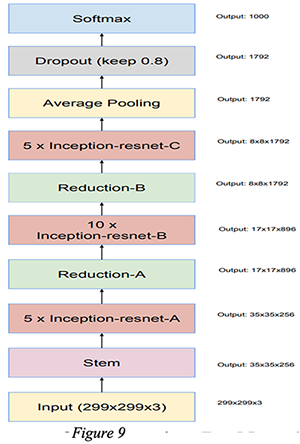

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [ ]:
# Compile Model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

In [ ]:
model.save('./object_detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# 5 - PipeLine for Object Detection Model

## 5.1 - Make Predictions

This is the final step in object detection. In this step, we will put it all together and get the prediction for a given image. First, I would like to try with one of my test pictures of car. Let load our model.

In [ ]:
# Load model
model = tf.keras.models.load_model('./object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


Next is loading our TEST picture with right path to it. I loaded some more images for this purpose only - folder TEST.

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/TEST/TEST1.jpeg'
image = load_img(path) #PIL Object
image = np.array(image, dtype=np.uint8) #8 bit array (0,255)

#For next step
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0 #Convert into array and Normalized output

# Size of Original Image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 742
Width of the image = 1200


Now we can have a look at our image Figure 13



In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700,height = 500, margin = dict(l=10,r=10,b=10, t=10),
                  xaxis_title = 'Figure 13 - TEST Image')
#fig.add_shape(type='rect',x0=113, x1=526, y0=140, y1=300, xref='x', yref='y',line_color='cyan')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Shape of Image
image_arr_224.shape

(224, 224, 3)

But in order to pass this image of a model, we need to provide the data in the dynamic fourth dimension. And what one indicates is a number of images. So here we are just passing only one image.

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

## 5.2 - DE-Normalize the Output

In [ ]:
# Make Predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 7s 7s/step


array([[0.24556617, 0.55087644, 0.4832701 , 0.51822096]], dtype=float32)

We have got the output from the model and output what we got is the normalized output. So, what we need to do is to convert back into our original form values, which actually we did in during the training process, in the training process, we have the original form values and convert that normalized one. So basically, we will de-normalize the values back.

In [ ]:
# Denormalize the Values
denorm = np.array([w,w,h,h])
coords = coords*denorm
coords

array([[ 471.48705482, 1057.68276215,  521.9317174 ,  559.67863798]])

## 5.3 - Bounding Box

Now we will draw bounding box on top of the image. I just want to provide the two diagonal points. Let's make use of these points and let's draw the rectangle box.

In [ ]:
coords = coords.astype(np.int32)
coords

array([[ 471, 1057,  521,  559]], dtype=int32)

In [ ]:
# Draw Bounding Box
xmin, xmax, ymin, ymax = coords[0]
pt1 = (xmin,ymin)
pt2 = (xmax, ymax)
print(pt1,pt2)

(471, 521) (1057, 559)


In [ ]:
cv2.rectangle(image, pt1, pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700,height=500,margin=dict(l=10,r=10,b=10,t=10))

Output hidden; open in https://colab.research.google.com to view.

## 5.4 Create Pipeline

All of the process together is called pipeline

In [ ]:

# Create pipeline
path = '/content/drive/MyDrive/Colab Notebooks/11 - Kaggle Practicing/7 - Automatic Number Plate Recognition/TEST/TEST1.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)


    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')


Output hidden; open in https://colab.research.google.com to view.